In [1]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import seaborn as sns
import matplotlib.image as mpimg
import os
from sqlalchemy import create_engine

In [2]:
client = bigquery.Client(project='subugoe-wag-closed')

In [3]:
openalex_snapshot = 'subugoe-collaborative.openalex.works'
openalex_sources = 'subugoe-collaborative.openalex.sources'
document_type_snapshot = 'subugoe-wag-closed.oal_doctypes.classification_article_reviews_september_2024'
cwts_snapshot = 'subugoe-wag-closed.cwts_2024.pub'
pubmed_snapshot = 'subugoe-wag-closed.pubmed.pubmed_bulk_dec_2022'
pubmed_hierarchy = 'subugoe-wag-closed.pubmed.pubmed_hierarchy'

In [4]:
sns.set_style('whitegrid')
plt.rc('font', family='Arial')
plt.rc('font', size=9) 
plt.rc('axes', titlesize=9) 
plt.rc('axes', labelsize=9) 
plt.rc('xtick', labelsize=9) 
plt.rc('ytick', labelsize=9) 
plt.rc('legend', fontsize=9)

In [47]:
df_doi = client.query(f"""
                       SELECT COUNT(DISTINCT(oal.doi)) AS n, label
                       FROM {openalex_snapshot} AS oal
                       JOIN {document_type_snapshot} AS dt
                           ON oal.doi = dt.doi
                       GROUP BY label
                       """).to_dataframe()

In [48]:
df_doi[df_doi['label'] == 'editorial_discourse'].n / df_doi.n.sum()

1    0.116309
Name: n, dtype: Float64

In [49]:
df_doi[df_doi['label'] == 'editorial_discourse'].n

1    12647946
Name: n, dtype: Int64

In [54]:
df_doi.n.sum()

108744219

In [50]:
df_doi_2012_2021 = client.query(f"""
                                 SELECT COUNT(DISTINCT(oal.doi)) AS n, label
                                 FROM {openalex_snapshot} AS oal
                                 JOIN {document_type_snapshot} AS dt
                                     ON oal.doi = dt.doi
                                 WHERE publication_year BETWEEN 2012 AND 2021
                                 GROUP BY label
                                 """).to_dataframe()

In [51]:
df_doi_2012_2021[df_doi_2012_2021['label'] == 'editorial_discourse'].n / df_doi_2012_2021.n.sum()

1    0.098742
Name: n, dtype: Float64

In [52]:
df_doi_2012_2021[df_doi_2012_2021['label'] == 'editorial_discourse'].n

1    3778393
Name: n, dtype: Int64

In [53]:
df_doi_2012_2021.n.sum()

38265399

In [9]:
df_cwts_2012_2021 = client.query(f"""
                                  SELECT COUNT(DISTINCT(cwts.doi)) AS n, 'research_discourse' AS label
                                  FROM {openalex_snapshot} AS oal
                                  LEFT JOIN {cwts_snapshot} AS cwts
                                      ON oal.doi = cwts.doi
                                  WHERE type IN ('article', 'review') 
                                      AND primary_location.source.type = 'journal' AND publication_year BETWEEN 2012 AND 2021 
                                  """).to_dataframe()

In [10]:
df_oal_2012_2021 = client.query(f"""
                                  SELECT COUNT(DISTINCT(oal.doi)) AS n
                                  FROM {openalex_snapshot} AS oal
                                  WHERE type IN ('article', 'review') 
                                      AND primary_location.source.type = 'journal' AND publication_year BETWEEN 2012 AND 2021
                                  """).to_dataframe()

In [11]:
df_cwts_2012_2021.n / df_oal_2012_2021.n

0    0.511614
Name: n, dtype: Float64

In [12]:
1 - 0.511614

0.488386

In [13]:
df_doi_cwts_2012_2022 = client.query(f"""
                                      SELECT COUNT(DISTINCT(oal.doi)) AS n, label
                                      FROM {openalex_snapshot} AS oal
                                      JOIN {document_type_snapshot} AS dt
                                          ON oal.doi = dt.doi
                                      JOIN {cwts_snapshot} AS cwts
                                          ON oal.doi = cwts.doi
                                      WHERE publication_year BETWEEN 2012 AND 2021
                                      GROUP BY label
                                      """).to_dataframe()

In [14]:
df_doi_cwts_2012_2022[df_doi_cwts_2012_2022['label'] == 'editorial_discourse'].n / df_doi_cwts_2012_2022.n.sum()

1    0.014541
Name: n, dtype: Float64

In [39]:
df_cwts_2012_2021 = client.query(f"""
                                  SELECT COUNT(DISTINCT(cwts.doi)) AS n, publication_year
                                  FROM {openalex_snapshot} AS oal
                                  LEFT JOIN {cwts_snapshot} AS cwts
                                      ON oal.doi = cwts.doi
                                  WHERE type IN ('article', 'review') 
                                      AND primary_location.source.type = 'journal' AND publication_year BETWEEN 2012 AND 2021 
                                  GROUP BY publication_year
                                  ORDER BY publication_year DESC
                                  """).to_dataframe()

In [40]:
df_doi_2012_2021 = client.query(f"""
                                 SELECT COUNT(DISTINCT(oal.doi)) AS n, publication_year
                                 FROM {openalex_snapshot} AS oal
                                 JOIN {document_type_snapshot} AS dt
                                     ON oal.doi = dt.doi
                                 WHERE publication_year BETWEEN 2012 AND 2021 AND label = 'research_discourse'
                                 GROUP BY publication_year
                                 ORDER BY publication_year DESC
                                 """).to_dataframe()

In [41]:
df_oal_2012_2021 = client.query(f"""
                                 SELECT COUNT(DISTINCT(oal.doi)) AS n, publication_year
                                 FROM {openalex_snapshot} AS oal
                                 WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2012 AND 2021
                                     AND type IN ('article', 'review')
                                 GROUP BY publication_year
                                 ORDER BY publication_year DESC
                                 """).to_dataframe()

In [42]:
df_oal_2012_2021_baseline = client.query(f"""
                                 SELECT COUNT(DISTINCT(oal.doi)) AS n, publication_year
                                 FROM {openalex_snapshot} AS oal
                                 WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2012 AND 2021
                                     AND ARRAY_LENGTH(referenced_works) != 0 AND cited_by_count != 0
                                     AND type IN ('article', 'review')
                                 GROUP BY publication_year
                                 ORDER BY publication_year DESC
                                 """).to_dataframe()

In [43]:
df_oal_2012_2021_all = client.query(f"""
                                     SELECT COUNT(DISTINCT(oal.doi)) AS n, publication_year
                                     FROM {openalex_snapshot} AS oal
                                     WHERE primary_location.source.type = 'journal' AND publication_year BETWEEN 2012 AND 2021
                                     GROUP BY publication_year
                                     ORDER BY publication_year DESC
                                     """).to_dataframe()

In [44]:
df_cwts_2012_2021['prop'] = df_cwts_2012_2021['n'] / df_oal_2012_2021_all['n'] 
df_doi_2012_2021['prop'] = df_doi_2012_2021['n'] / df_oal_2012_2021_all['n']
df_oal_2012_2021['prop'] = df_oal_2012_2021['n'] / df_oal_2012_2021_all['n']
df_oal_2012_2021_baseline['prop'] = df_oal_2012_2021_baseline['n'] / df_oal_2012_2021_all['n']

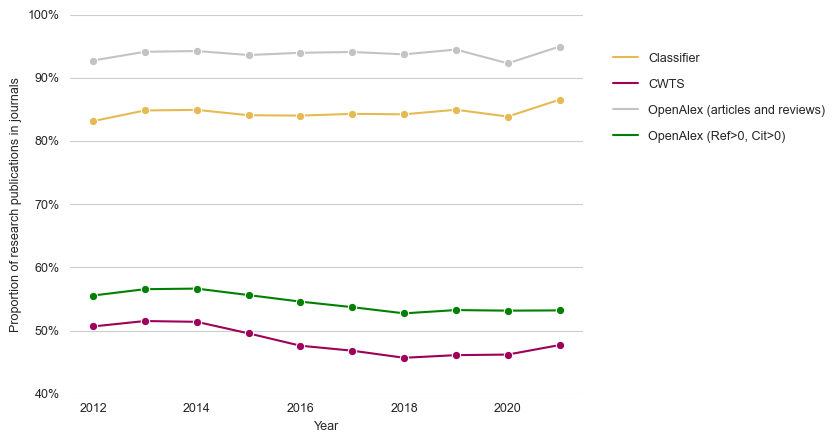

In [45]:
fig, ax = plt.subplots(figsize=(6,4.5))
plt.box(False)

sns.lineplot(data=df_doi_2012_2021,
             x='publication_year',
             y='prop',
             color='#E5BA52',
             marker='o',
             ax=ax)

sns.lineplot(data=df_cwts_2012_2021,
             x='publication_year',
             y='prop',
             color='#9e0059',
             marker='o',
             ax=ax)

sns.lineplot(data=df_oal_2012_2021,
             x='publication_year',
             y='prop',
             color='#c3c3c3',
             marker='o',
             ax=ax)

sns.lineplot(data=df_oal_2012_2021_baseline,
             x='publication_year',
             y='prop',
             color='green',
             marker='o',
             ax=ax)

#ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.grid(False, which='both', axis='x')
ax.set(xlabel='Year', ylabel='Proportion of research publications in journals')

ax.set_ylim(0.4, 1)

clas_patch = Line2D([0], [0], color='#E5BA52', label='Classifier')
cwts_patch = Line2D([0], [0], color='#9e0059', label='CWTS')
oal_patch = Line2D([0], [0], color='#c3c3c3', label='OpenAlex (articles and reviews)')
oal_baseline_patch = Line2D([0], [0], color='green', label='OpenAlex (Ref>0, Cit>0)')

lgd = fig.legend(handles=[clas_patch, cwts_patch, oal_patch, oal_baseline_patch], frameon=False,
                 bbox_to_anchor=(1.4, 0.9), labelspacing=1.1)

plt.tight_layout()

plt.show()
fig.savefig(f'media/oal_cwts_comparison.png', format='png', bbox_inches='tight', dpi=500)

In [32]:
df_cwts_2012_2021_core = client.query(f"""
                                       SELECT COUNT(DISTINCT(cwts.doi)) AS n, publication_year
                                       FROM {openalex_snapshot} AS oal
                                       LEFT JOIN {cwts_snapshot} AS cwts
                                           ON oal.doi = cwts.doi
                                       LEFT JOIN {openalex_sources} AS sources
                                           ON primary_location.source.id = sources.id
                                       WHERE oal.type IN ('article', 'review') AND sources.type = 'journal'
                                           AND sources.is_core=TRUE AND publication_year BETWEEN 2012 AND 2021 
                                       GROUP BY publication_year
                                       ORDER BY publication_year DESC
                                       """).to_dataframe()

In [33]:
df_doi_2012_2021_core = client.query(f"""
                                      SELECT COUNT(DISTINCT(oal.doi)) AS n, publication_year
                                      FROM {openalex_snapshot} AS oal
                                      JOIN {document_type_snapshot} AS dt
                                          ON oal.doi = dt.doi
                                      LEFT JOIN {openalex_sources} AS sources
                                          ON primary_location.source.id = sources.id
                                      WHERE sources.type = 'journal' AND sources.is_core=TRUE 
                                          AND publication_year BETWEEN 2012 AND 2021 AND label = 'research_discourse'
                                      GROUP BY publication_year
                                      ORDER BY publication_year DESC
                                      """).to_dataframe()

In [34]:
df_oal_2012_2021_core = client.query(f"""
                                      SELECT COUNT(DISTINCT(oal.doi)) AS n, publication_year
                                      FROM {openalex_snapshot} AS oal
                                      LEFT JOIN {openalex_sources} AS sources
                                          ON primary_location.source.id = sources.id
                                      WHERE sources.type = 'journal' AND sources.is_core=TRUE AND publication_year BETWEEN 2012 AND 2021
                                          AND oal.type IN ('article', 'review')
                                      GROUP BY publication_year
                                      ORDER BY publication_year DESC
                                      """).to_dataframe()

In [35]:
df_oal_2012_2021_baseline_core = client.query(f"""
                                               SELECT COUNT(DISTINCT(oal.doi)) AS n, publication_year
                                               FROM {openalex_snapshot} AS oal
                                               LEFT JOIN {openalex_sources} AS sources
                                                   ON primary_location.source.id = sources.id
                                               WHERE sources.type = 'journal' AND sources.is_core=TRUE 
                                                   AND publication_year BETWEEN 2012 AND 2021
                                                   AND ARRAY_LENGTH(referenced_works) != 0 AND oal.cited_by_count != 0
                                                   AND oal.type IN ('article', 'review')
                                               GROUP BY publication_year
                                               ORDER BY publication_year DESC
                                               """).to_dataframe()

In [36]:
df_oal_2012_2021_all_core = client.query(f"""
                                          SELECT COUNT(DISTINCT(oal.doi)) AS n, publication_year
                                          FROM {openalex_snapshot} AS oal
                                          LEFT JOIN {openalex_sources} AS sources
                                              ON primary_location.source.id = sources.id
                                          WHERE sources.type = 'journal' AND sources.is_core=TRUE 
                                              AND publication_year BETWEEN 2012 AND 2021
                                          GROUP BY publication_year
                                          ORDER BY publication_year DESC 
                                          """).to_dataframe()

In [37]:
df_cwts_2012_2021_core['prop'] = df_cwts_2012_2021_core['n'] / df_oal_2012_2021_all_core['n'] 
df_doi_2012_2021_core['prop'] = df_doi_2012_2021_core['n'] / df_oal_2012_2021_all_core['n']
df_oal_2012_2021_core['prop'] = df_oal_2012_2021_core['n'] / df_oal_2012_2021_all_core['n']
df_oal_2012_2021_baseline_core['prop'] = df_oal_2012_2021_baseline_core['n'] / df_oal_2012_2021_all_core['n']

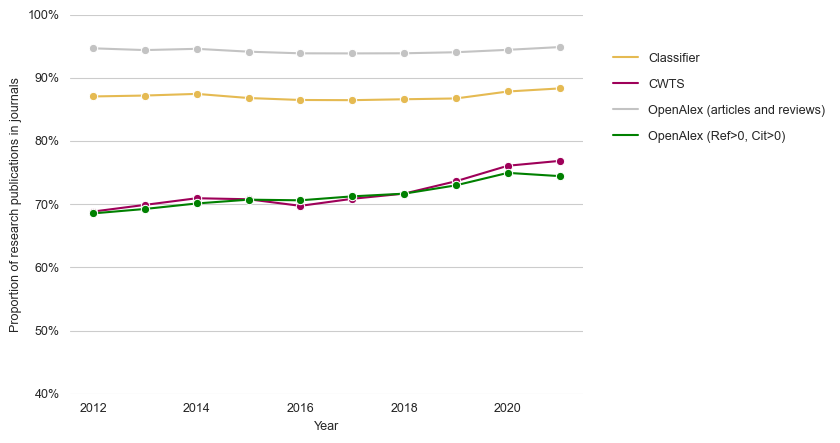

In [38]:
fig, ax = plt.subplots(figsize=(6,4.5))
plt.box(False)

sns.lineplot(data=df_doi_2012_2021_core,
             x='publication_year',
             y='prop',
             color='#E5BA52',
             marker='o',
             ax=ax)

sns.lineplot(data=df_cwts_2012_2021_core,
             x='publication_year',
             y='prop',
             color='#9e0059',
             marker='o',
             ax=ax)

sns.lineplot(data=df_oal_2012_2021_core,
             x='publication_year',
             y='prop',
             color='#c3c3c3',
             marker='o',
             ax=ax)

sns.lineplot(data=df_oal_2012_2021_baseline_core,
             x='publication_year',
             y='prop',
             color='green',
             marker='o',
             ax=ax)

#ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.grid(False, which='both', axis='x')
ax.set(xlabel='Year', ylabel='Proportion of research publications in journals')

ax.set_ylim(0.4, 1)

clas_patch = Line2D([0], [0], color='#E5BA52', label='Classifier')
cwts_patch = Line2D([0], [0], color='#9e0059', label='CWTS')
oal_patch = Line2D([0], [0], color='#c3c3c3', label='OpenAlex (articles and reviews)')
oal_baseline_patch = Line2D([0], [0], color='green', label='OpenAlex (Ref>0, Cit>0)')

lgd = fig.legend(handles=[clas_patch, cwts_patch, oal_patch, oal_baseline_patch], frameon=False,
                 bbox_to_anchor=(1.4, 0.9), labelspacing=1.1)

plt.tight_layout()

plt.show()
fig.savefig(f'media/oal_cwts_comparison_core.png', format='png', bbox_inches='tight', dpi=500)

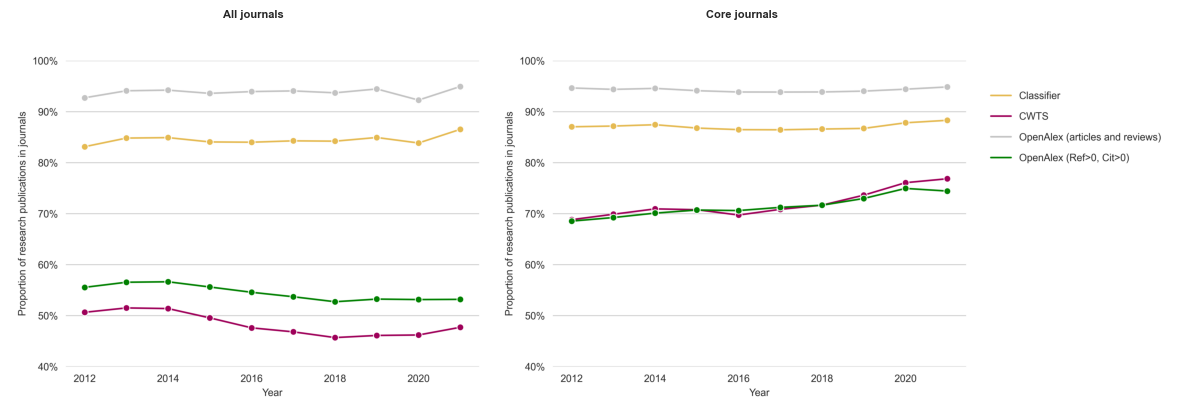

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
filelist =  ['oal_cwts_comparison', 'oal_cwts_comparison_core']
for i, (ax, file) in enumerate(zip(axs.flat, filelist)):
    ax.set_axis_off()
    filename = 'media/' + file + '.png'
    ax.imshow(mpimg.imread(filename), extent=None)
plt.subplots_adjust(wspace=-0.28, hspace=0)
plt.text(-1700, -200, 'All journals', size=8, weight='bold')
plt.text(1300, -200, 'Core journals', size=8, weight='bold')
plt.show()
fig.savefig('media/figure1.png', format='png', bbox_inches='tight', dpi=500)

In [32]:
df_doi_2012_2021_topic = client.query(f"""
                                       SELECT COUNT(DISTINCT(oal.doi)) AS n, label, primary_topic.domain.display_name AS topic
                                       FROM {openalex_snapshot} AS oal
                                       JOIN {document_type_snapshot} AS dt
                                           ON oal.doi = dt.doi
                                       WHERE publication_year BETWEEN 2012 AND 2021
                                       GROUP BY topic, label
                                       """).to_dataframe()

In [33]:
df_doi_2012_2021_topic = df_doi_2012_2021_topic.fillna(value='No topic assigned')

In [34]:
df_doi_2012_2021_topic

,n,label,topic
0,362442,editorial_discourse,Life Sciences
1,1364878,research_discourse,No topic assigned
2,608605,editorial_discourse,Physical Sciences
3,12058925,research_discourse,Physical Sciences
4,8566916,research_discourse,Health Sciences
5,1258170,editorial_discourse,Health Sciences
6,7586012,research_discourse,Social Sciences
7,1022687,editorial_discourse,Social Sciences
8,4910689,research_discourse,Life Sciences
9,526533,editorial_discourse,No topic assigned


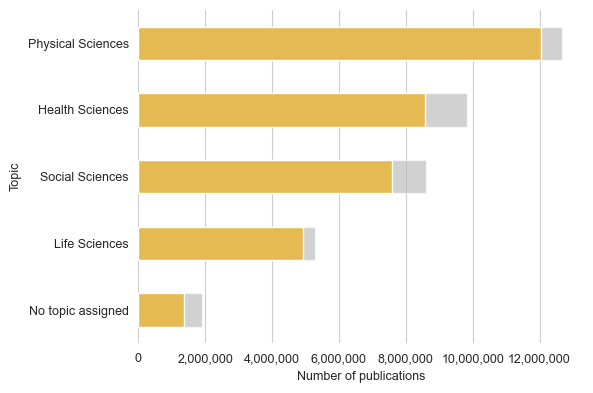

In [35]:
fig, ax = plt.subplots(figsize=(6,4))
plt.box(False)

sns.barplot(data=df_doi_2012_2021_topic.groupby(['topic'])['n'].sum().reset_index(), 
            x='n', 
            y='topic', 
            alpha=0.6,
            color='#b3b3b3a0',
            order=['Physical Sciences', 'Health Sciences', 'Social Sciences', 'Life Sciences', 'No topic assigned'],
            width=0.5,
            saturation=1,
            errorbar=None)

sns.barplot(data=df_doi_2012_2021_topic[df_doi_2012_2021_topic.label == 'research_discourse'], 
            x='n', 
            y='topic', 
            alpha=1,
            color='#E5BA52',
            order=['Physical Sciences', 'Health Sciences', 'Social Sciences', 'Life Sciences', 'No topic assigned'],
            width=0.5,
            saturation=1,
            errorbar=None)

ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

ax.set(xlabel='Number of publications', ylabel='Topic')

plt.tight_layout()

plt.show()
fig.savefig(f'media/dt_topics.png', format='png', bbox_inches='tight', dpi=500)

In [36]:
df_doi_2012_2021_oa = client.query(f"""
                                    SELECT COUNT(DISTINCT(oal.doi)) AS n, label, open_access.is_oa AS is_oa
                                    FROM {openalex_snapshot} AS oal
                                    JOIN {document_type_snapshot} AS dt
                                        ON oal.doi = dt.doi
                                    WHERE publication_year BETWEEN 2012 AND 2021
                                    GROUP BY is_oa, label
                                    """).to_dataframe()

In [37]:
df_doi_2012_2021_oa['prop'] = df_doi_2012_2021_oa.n / df_doi_2012_2021_oa.n.sum()

In [38]:
df_doi_2012_2021_oa

,n,label,is_oa,prop
0,16406034,research_discourse,False,0.428741
1,18081146,research_discourse,True,0.472517
2,2003511,editorial_discourse,True,0.052358
3,1774908,editorial_discourse,False,0.046384


In [39]:
df_doi_2012_2021_topic_cwts = client.query(f"""
                                            SELECT COUNT(DISTINCT(oal.doi)) AS oal_n, COUNT(DISTINCT(cwts.doi)) AS cwts_n,
                                                primary_topic.domain.display_name AS topic
                                            FROM {openalex_snapshot} AS oal
                                            LEFT JOIN {cwts_snapshot} AS cwts
                                                ON oal.doi = cwts.doi
                                            WHERE type IN ('article', 'review') 
                                                AND primary_location.source.type = 'journal' AND publication_year BETWEEN 2012 AND 2021
                                            GROUP BY topic
                                            """).to_dataframe()

In [40]:
df_doi_2012_2021_topic_cwts = df_doi_2012_2021_topic_cwts.fillna(value='No topic assigned')

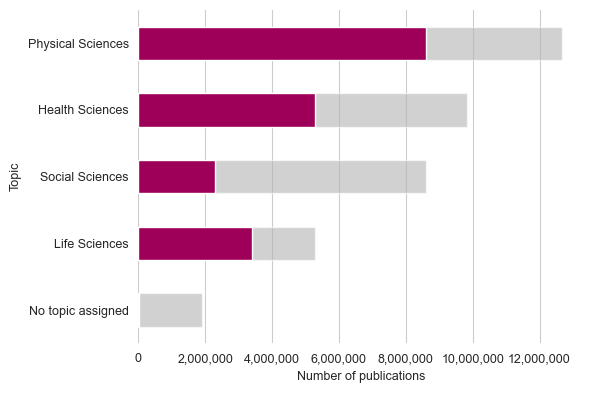

In [41]:
fig, ax = plt.subplots(figsize=(6,4))
plt.box(False)

sns.barplot(data=df_doi_2012_2021_topic_cwts, 
            x='oal_n', 
            y='topic', 
            alpha=0.6,
            color='#b3b3b3a0',
            order=['Physical Sciences', 'Health Sciences', 'Social Sciences', 'Life Sciences', 'No topic assigned'],
            width=0.5,
            saturation=1,
            errorbar=None)

sns.barplot(data=df_doi_2012_2021_topic_cwts, 
            x='cwts_n', 
            y='topic', 
            alpha=1,
            color='#9e0059',
            order=['Physical Sciences', 'Health Sciences', 'Social Sciences', 'Life Sciences', 'No topic assigned'],
            width=0.5,
            saturation=1,
            errorbar=None)

ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

ax.set(xlabel='Number of publications', ylabel='Topic')

plt.tight_layout()

plt.show()
fig.savefig(f'media/cwts_topics.png', format='png', bbox_inches='tight', dpi=500)

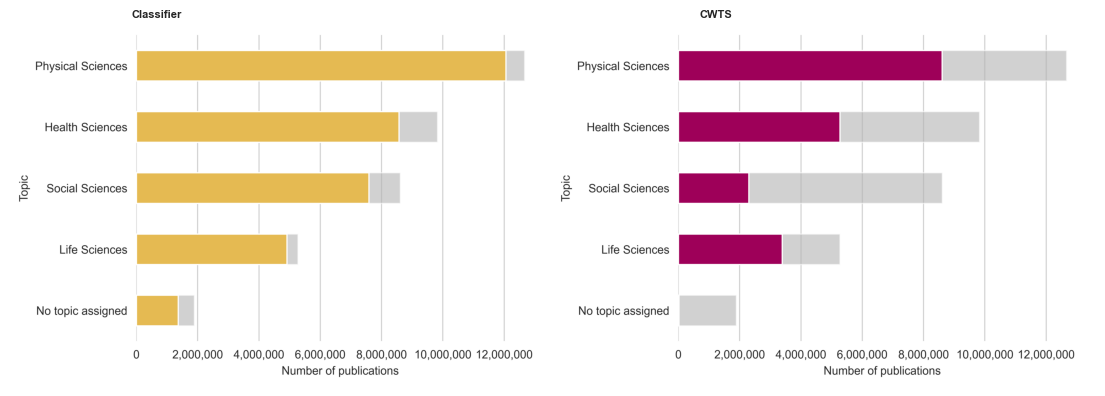

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(14, 8))
filelist =  ['dt_topics', 'cwts_topics']
for i, (ax, file) in enumerate(zip(axs.flat, filelist)):
    ax.set_axis_off()
    filename = 'media/' + file + '.png'
    ax.imshow(mpimg.imread(filename), extent=None)
plt.subplots_adjust(wspace=0, hspace=0)
plt.text(-2300, -50, 'Classifier', size=8, weight='bold')
plt.text(800, -50, 'CWTS', size=8, weight='bold')
plt.show()
fig.savefig('media/figure3.png', format='png', bbox_inches='tight', dpi=500)

In [6]:
df_doi_2012_2021_topic_core = client.query(f"""
                                            SELECT COUNT(DISTINCT(oal.doi)) AS n, label, primary_topic.domain.display_name AS topic
                                            FROM {openalex_snapshot} AS oal
                                            JOIN {document_type_snapshot} AS dt
                                                ON oal.doi = dt.doi
                                            LEFT JOIN {openalex_sources} AS sources
                                                ON primary_location.source.id = sources.id
                                            WHERE sources.type = 'journal' AND sources.is_core=TRUE 
                                                AND publication_year BETWEEN 2012 AND 2021
                                            GROUP BY topic, label
                                            """).to_dataframe()

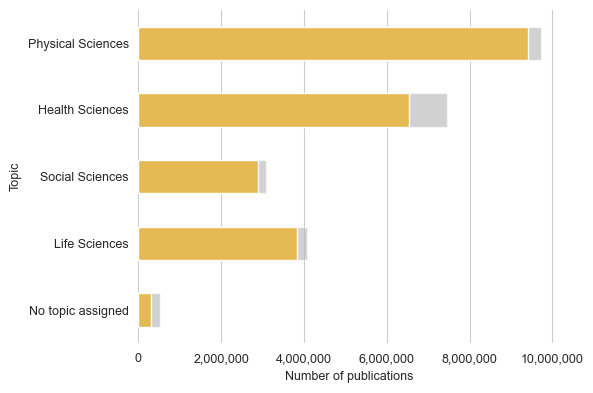

In [7]:
df_doi_2012_2021_topic_core = df_doi_2012_2021_topic_core.fillna(value='No topic assigned')

fig, ax = plt.subplots(figsize=(6,4))
plt.box(False)

sns.barplot(data=df_doi_2012_2021_topic_core.groupby(['topic'])['n'].sum().reset_index(), 
            x='n', 
            y='topic', 
            alpha=0.6,
            color='#b3b3b3a0',
            order=['Physical Sciences', 'Health Sciences', 'Social Sciences', 'Life Sciences', 'No topic assigned'],
            width=0.5,
            saturation=1,
            errorbar=None)

sns.barplot(data=df_doi_2012_2021_topic_core[df_doi_2012_2021_topic_core.label == 'research_discourse'], 
            x='n', 
            y='topic', 
            alpha=1,
            color='#E5BA52',
            order=['Physical Sciences', 'Health Sciences', 'Social Sciences', 'Life Sciences', 'No topic assigned'],
            width=0.5,
            saturation=1,
            errorbar=None)

ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

ax.set(xlabel='Number of publications', ylabel='Topic')

plt.tight_layout()

plt.show()
fig.savefig(f'media/dt_topics_core.png', format='png', bbox_inches='tight', dpi=500)

In [9]:
df_doi_2012_2021_topic_cwts_core = client.query(f"""
                                                 SELECT COUNT(DISTINCT(oal.doi)) AS oal_n, COUNT(DISTINCT(cwts.doi)) AS cwts_n,
                                                     primary_topic.domain.display_name AS topic
                                                 FROM {openalex_snapshot} AS oal
                                                 LEFT JOIN {cwts_snapshot} AS cwts
                                                     ON oal.doi = cwts.doi
                                                 LEFT JOIN {openalex_sources} AS sources
                                                     ON primary_location.source.id = sources.id
                                                 WHERE oal.type IN ('article', 'review') 
                                                     AND sources.type = 'journal' AND sources.is_core=TRUE 
                                                     AND publication_year BETWEEN 2012 AND 2021
                                                 GROUP BY topic
                                                 """).to_dataframe()

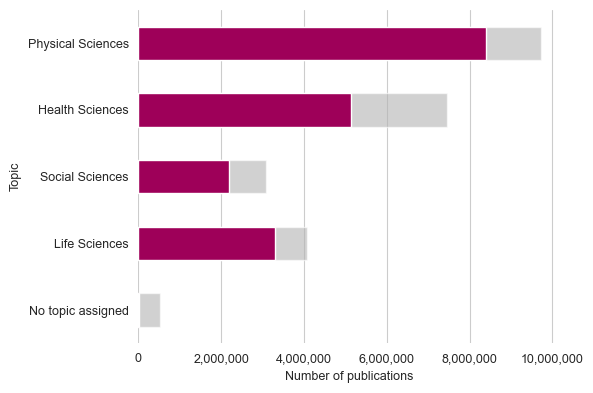

In [10]:
df_doi_2012_2021_topic_cwts_core = df_doi_2012_2021_topic_cwts_core.fillna(value='No topic assigned')

fig, ax = plt.subplots(figsize=(6,4))
plt.box(False)

sns.barplot(data=df_doi_2012_2021_topic_cwts_core, 
            x='oal_n', 
            y='topic', 
            alpha=0.6,
            color='#b3b3b3a0',
            order=['Physical Sciences', 'Health Sciences', 'Social Sciences', 'Life Sciences', 'No topic assigned'],
            width=0.5,
            saturation=1,
            errorbar=None)

sns.barplot(data=df_doi_2012_2021_topic_cwts_core, 
            x='cwts_n', 
            y='topic', 
            alpha=1,
            color='#9e0059',
            order=['Physical Sciences', 'Health Sciences', 'Social Sciences', 'Life Sciences', 'No topic assigned'],
            width=0.5,
            saturation=1,
            errorbar=None)

ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

ax.set(xlabel='Number of publications', ylabel='Topic')

plt.tight_layout()

plt.show()
fig.savefig(f'media/cwts_topics_core.png', format='png', bbox_inches='tight', dpi=500)

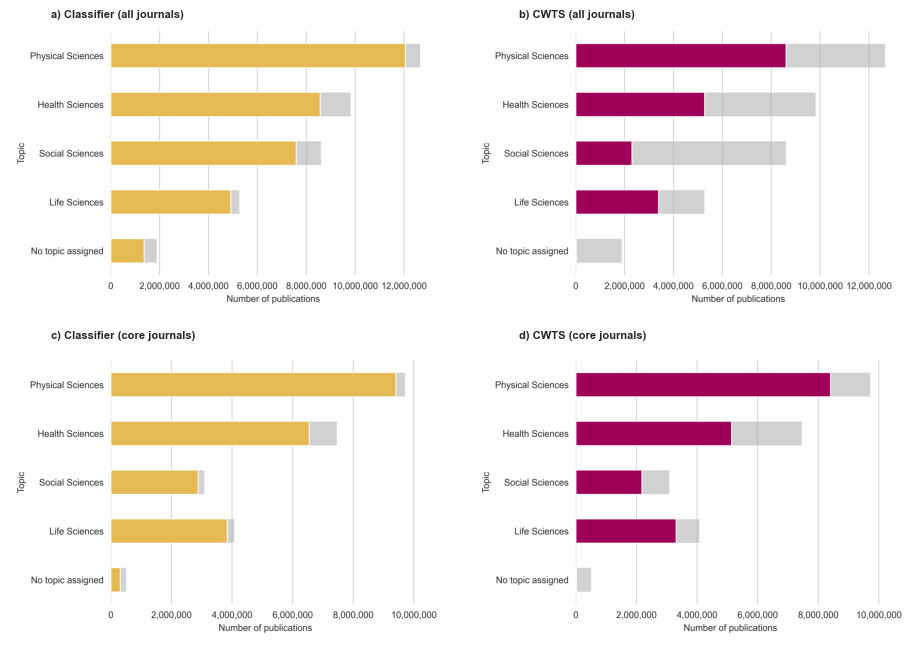

In [35]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8))
filelist =  ['dt_topics', 'cwts_topics', 'dt_topics_core', 'cwts_topics_core']
for i, (ax, file) in enumerate(zip(axs.flat, filelist)):
    ax.set_axis_off()
    filename = 'media/' + file + '.png'
    ax.imshow(mpimg.imread(filename), extent=None)
plt.subplots_adjust(wspace=-0.25, hspace=0.15)
plt.text(-2900, -2300, 'a) Classifier (all journals)', size=8, weight='bold')
plt.text(300, -2300, 'b) CWTS (all journals)', size=8, weight='bold')
plt.text(-2900, -100, 'c) Classifier (core journals)', size=8, weight='bold')
plt.text(300, -100, 'd) CWTS (core journals)', size=8, weight='bold')
plt.show()
fig.savefig('media/topics_extended.png', format='png', bbox_inches='tight', dpi=500)

In [43]:
df_doi_2012_2021_proba_dist = client.query(f"""
                                            SELECT COUNT(DISTINCT(dt.doi)) AS n, ROUND(proba, 1) AS proba_rounded
                                            FROM {openalex_snapshot} AS oal
                                            JOIN {document_type_snapshot} AS dt
                                                ON oal.doi = dt.doi
                                            WHERE publication_year BETWEEN 2012 AND 2021
                                            GROUP BY proba_rounded
                                            """).to_dataframe()

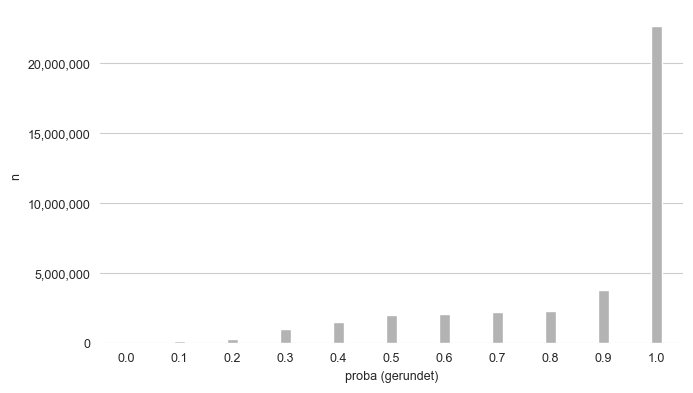

In [44]:
fig, ax = plt.subplots(figsize=(7,4))
plt.box(False)

sns.barplot(data=df_doi_2012_2021_proba_dist, 
            x='proba_rounded', 
            y='n', 
            alpha=1,
            color='#b3b3b3a0',
            width=0.2,
            saturation=1,
            errorbar=None)

ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

ax.set(xlabel='proba (gerundet)', ylabel='n')

plt.tight_layout()

plt.show()

In [33]:
df_doi_2012_2021_pubmed = client.query(f"""
                                       SELECT COUNT(DISTINCT(dt.doi)) AS dt_n, COUNT(DISTINCT(pm.doi)) AS pm_n,
                                           label
                                       FROM {openalex_snapshot} AS oal
                                       JOIN {document_type_snapshot} AS dt
                                           ON oal.doi = dt.doi
                                       LEFT JOIN (
                                           SELECT doi 
                                           FROM {pubmed_snapshot} AS pm_snapshot
                                           JOIN {pubmed_hierarchy} AS pm_hierarchy
                                               ON pm_snapshot.grouprank = pm_hierarchy.grouprank
                                           WHERE pm_hierarchy.ptype_group IN ('RCT', 'Case_Reports')
                                       ) AS pm
                                           ON LOWER(oal.doi) = LOWER(pm.doi)
                                       WHERE publication_year BETWEEN 2012 AND 2021
                                       GROUP BY label
                                       """).to_dataframe()

In [34]:
df_doi_2012_2021_pubmed

,dt_n,pm_n,label
0,34487006,800126,research_discourse
1,3778393,27650,editorial_discourse


In [35]:
df_doi_2012_2021_publisher = client.query(f"""
                                           SELECT COUNT(DISTINCT(oal.doi)) AS n, label, 
                                               oal_sources.host_organization_name AS publisher
                                           FROM {openalex_snapshot} AS oal
                                           JOIN {document_type_snapshot} AS dt
                                               ON oal.doi = dt.doi 
                                           JOIN {openalex_sources} AS oal_sources
                                               ON oal.primary_location.source.id = oal_sources.id
                                           WHERE publication_year BETWEEN 2012 AND 2021
                                               AND oal_sources.type = 'journal'
                                           GROUP BY publisher, label
                                           """).to_dataframe()

In [36]:
df_doi_2012_2021_publisher_total = df_doi_2012_2021_publisher.groupby(['publisher'])['n'].sum().reset_index()
df_doi_2012_2021_publisher_total = df_doi_2012_2021_publisher_total.rename(columns={'n': 'n_total'})

In [37]:
df_doi_2012_2021_publisher = df_doi_2012_2021_publisher.merge(df_doi_2012_2021_publisher_total, on='publisher')
df_doi_2012_2021_publisher['prop'] = (df_doi_2012_2021_publisher.n / df_doi_2012_2021_publisher.n_total) * 100

In [38]:
df_doi_2012_2021_publisher[(df_doi_2012_2021_publisher.n_total > 10000) & (df_doi_2012_2021_publisher.label == 'research_discourse')] \
    .sort_values(by='prop', ascending=True).head(10)

,n,label,publisher,n_total,prop
6627,28712,research_discourse,"Adis, Springer Healthcare",152464,18.831987
11272,6764,research_discourse,Royal Pharmaceutical Society,15170,44.588003
8677,15302,research_discourse,Royal College of Nursing,33166,46.137611
6533,8733,research_discourse,OpenEdition Journals,18472,47.27696
8709,18733,research_discourse,Case Journals,38202,49.0367
4303,15348,research_discourse,Massachusetts Medical Society,27006,56.831815
2331,7429,research_discourse,International Union of Crystallography,12818,57.95756
10968,19775,research_discourse,EMH Swiss Medical Publishers Ltd.,33635,58.792924
6557,8939,research_discourse,AIP Publishing,14670,60.933879
10734,7493,research_discourse,Indiana University Press,11464,65.36113


In [39]:
df_doi_2012_2021_publisher[(df_doi_2012_2021_publisher.n_total > 10000) & (df_doi_2012_2021_publisher.label == 'research_discourse')] \
    .sort_values(by='prop', ascending=False).head()

,n,label,publisher,n_total,prop
6519,189663,research_discourse,Trans Tech Publications,189703,99.978914
10817,11565,research_discourse,Ivyspring International Publisher,11578,99.887718
8662,13437,research_discourse,"PeerJ, Inc.",13453,99.881067
10835,21941,research_discourse,Excellent Publishers,21972,99.858911
2477,12151,research_discourse,Aurora Group s.r.o.,12170,99.843878


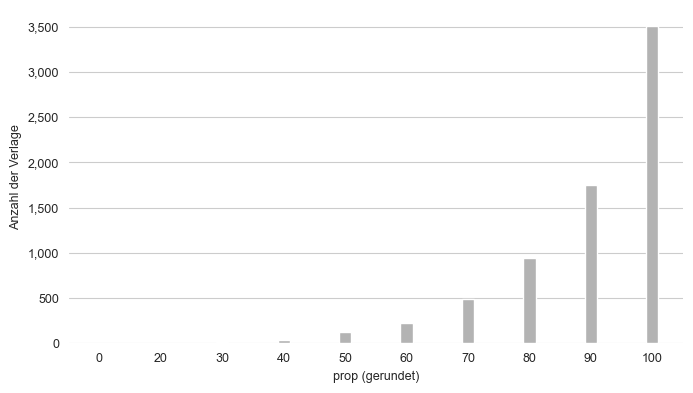

In [40]:
df_plot = df_doi_2012_2021_publisher[df_doi_2012_2021_publisher.label == 'research_discourse'].copy()
df_plot['prop_rounded'] = df_plot['prop'].apply(lambda x: round(x / 10) * 10)
df_plot = df_plot.groupby(['prop_rounded']).publisher.count().reset_index()

fig, ax = plt.subplots(figsize=(7,4))
plt.box(False)

sns.barplot(data=df_plot, 
            x='prop_rounded', 
            y='publisher', 
            alpha=1,
            color='#b3b3b3a0',
            width=0.2,
            saturation=1,
            errorbar=None)

ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

ax.set(xlabel='prop (gerundet)', ylabel='Anzahl der Verlage')

plt.tight_layout()

plt.show()

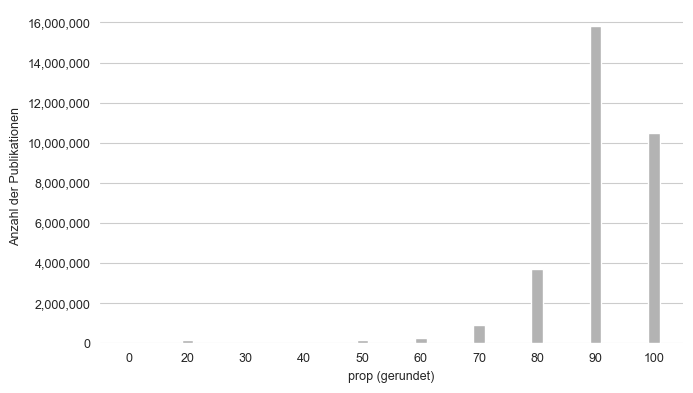

In [41]:
df_plot = df_doi_2012_2021_publisher[df_doi_2012_2021_publisher.label == 'research_discourse'].copy()
df_plot['prop_rounded'] = df_plot['prop'].apply(lambda x: round(x / 10) * 10)
df_plot = df_plot.groupby(['prop_rounded']).n_total.sum().reset_index()

fig, ax = plt.subplots(figsize=(7,4))
plt.box(False)

sns.barplot(data=df_plot, 
            x='prop_rounded', 
            y='n_total', 
            alpha=1,
            color='#b3b3b3a0',
            width=0.2,
            saturation=1,
            errorbar=None)

ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

ax.set(xlabel='prop (gerundet)', ylabel='Anzahl der Publikationen')

plt.tight_layout()

plt.show()

In [42]:
df_doi_2012_2021_language = client.query(f"""
                                          SELECT COUNT(DISTINCT(oal.doi)) AS n, label, language
                                          FROM {openalex_snapshot} AS oal
                                          JOIN {document_type_snapshot} AS dt
                                              ON oal.doi = dt.doi
                                          WHERE publication_year BETWEEN 2012 AND 2021
                                          GROUP BY language, label
                                          """).to_dataframe()

In [43]:
df_doi_2012_2021_language_total = df_doi_2012_2021_language.groupby(['language'])['n'].sum().reset_index()
df_doi_2012_2021_language_total.rename(columns={'n': 'n_total'}, inplace=True)
df_doi_2012_2021_language = df_doi_2012_2021_language.merge(df_doi_2012_2021_language_total, on='language')
df_doi_2012_2021_language['prop'] = (df_doi_2012_2021_language.n / df_doi_2012_2021_language.n_total)

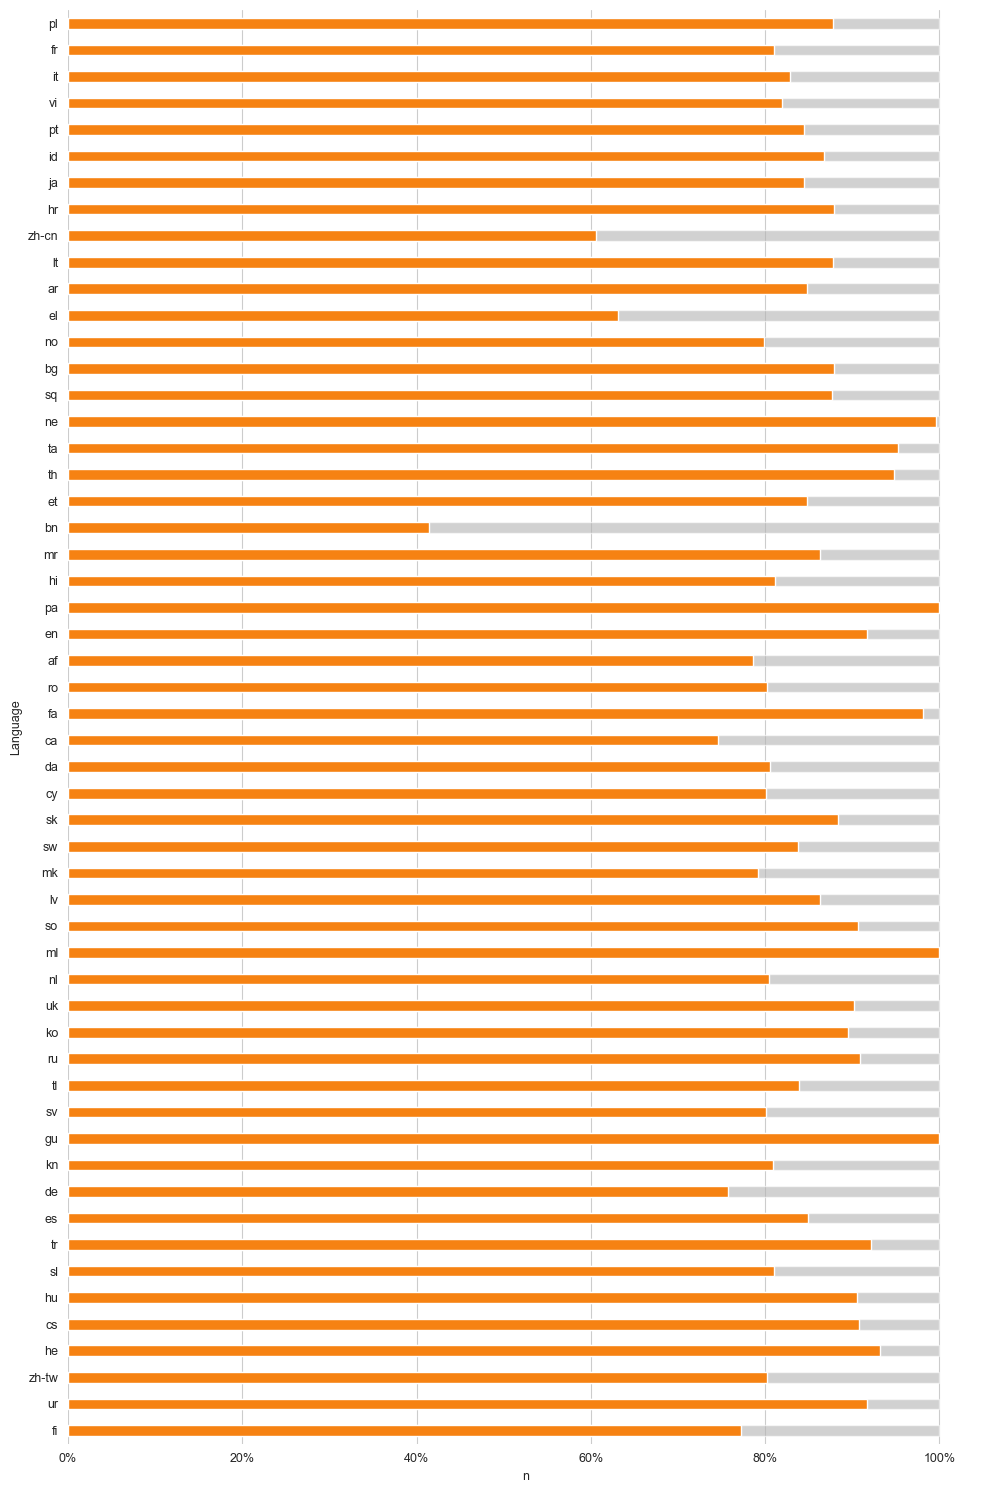

In [44]:
fig, ax = plt.subplots(figsize=(10,15))
plt.box(False)

sns.barplot(data=df_doi_2012_2021_language, 
            x=1, 
            y='language', 
            alpha=0.6,
            color='#b3b3b3a0',
            width=0.4,
            saturation=1,
            errorbar=None)

sns.barplot(data=df_doi_2012_2021_language[df_doi_2012_2021_language.label == 'research_discourse'], 
            x='prop', 
            y='language', 
            alpha=1,
            color='#f68212',
            width=0.4,
            saturation=1,
            errorbar=None)

ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax.set(xlabel='n', ylabel='Language')

plt.tight_layout()

plt.show()
fig.savefig(f'media/dt_languages.png', format='png', bbox_inches='tight', dpi=500)

## Abgleich mit dem KB

In [6]:
host = os.environ['KB_HOST']
database = os.environ['KB_DATABASE']
user = os.environ['KB_USER']
pw = os.environ['KB_PASSWORD']
port = os.environ['KB_PORT']
engine = create_engine(f'postgresql://{user}:{pw}@{host}:{port}/{database}')

In [7]:
scp_cla_n = pd.read_sql("""
                        SELECT COUNT(DISTINCT(dt.doi)) AS n, label
                        FROM unignhaupka.classification_article_reviews_september_2024 AS dt
                        JOIN scp_b_202407.items scp
                            ON LOWER(dt.doi) = LOWER(scp.doi)
                        WHERE ('Article' = ANY(item_type) OR 'Review' = ANY(item_type)) AND (scp.pubyear BETWEEN 2012 AND 2021)
                        GROUP BY label
                        """, 
                        con=engine)

In [8]:
scp_cla_n[scp_cla_n['label'] == 'editorial_discourse'].n / scp_cla_n.n.sum()

0    0.012524
Name: n, dtype: float64

In [23]:
oal_n = pd.read_sql("""
                    SELECT COUNT(DISTINCT(oal.doi)) AS n, oal.publication_year 
                    FROM unignhaupka.oal_dois_september_2024_with_pubyear AS oal
                    JOIN scp_b_202407.items AS scp
                        ON LOWER(oal.doi) = LOWER(scp.doi)
                    WHERE oal.type IN ('article', 'review')  
                        -- AND oal.source_type = 'journal' AND oal.publication_year BETWEEN 2012 AND 2021
                    GROUP BY oal.publication_year 
                    """, 
                    con=engine)

In [24]:
scp_n = pd.read_sql("""
                    SELECT COUNT(DISTINCT(oal.doi)) AS n, oal.publication_year
                    FROM unignhaupka.oal_dois_september_2024_with_pubyear AS oal
                    JOIN scp_b_202407.items AS scp
                        ON LOWER(oal.doi) = LOWER(scp.doi)
                    WHERE ('Article' = ANY(scp.item_type) OR 'Review' = ANY(scp.item_type))
                        -- AND oal.source_type = 'journal' AND oal.publication_year BETWEEN 2012 AND 2021
                    GROUP BY oal.publication_year 
                    """, 
                    con=engine)

In [25]:
dt_n = pd.read_sql("""
                   SELECT COUNT(DISTINCT(dt.doi)) AS n, oal.publication_year
                   FROM unignhaupka.classification_article_reviews_september_2024 AS dt
                   JOIN scp_b_202407.items AS scp
                       ON LOWER(dt.doi) = LOWER(scp.doi)
                   JOIN unignhaupka.oal_dois_september_2024_with_pubyear AS oal
                       ON LOWER(dt.doi) = LOWER(oal.doi)
                   WHERE label = 'research_discourse'
                   -- AND oal.source_type = 'journal' AND oal.publication_year BETWEEN 2012 AND 2021
                   GROUP BY oal.publication_year 
                   """, 
                   con=engine)

In [26]:
all_n = pd.read_sql("""
                   SELECT COUNT(DISTINCT(oal.doi)) AS n
                   FROM unignhaupka.oal_dois_september_2024_with_pubyear AS oal
                   JOIN scp_b_202407.items AS scp
                       ON LOWER(oal.doi) = LOWER(scp.doi)
                   -- WHERE oal.publication_year BETWEEN 2012 AND 2021
                   -- AND oal.source_type = 'journal'
                   """, 
                   con=engine)

In [27]:
oal_n.n.sum() / all_n.n.sum()

0.9580456912012387

In [28]:
scp_n.n.sum() / all_n.n.sum()

0.8778790243112012

In [29]:
dt_n.n.sum() / all_n.n.sum()

0.9326074906717116

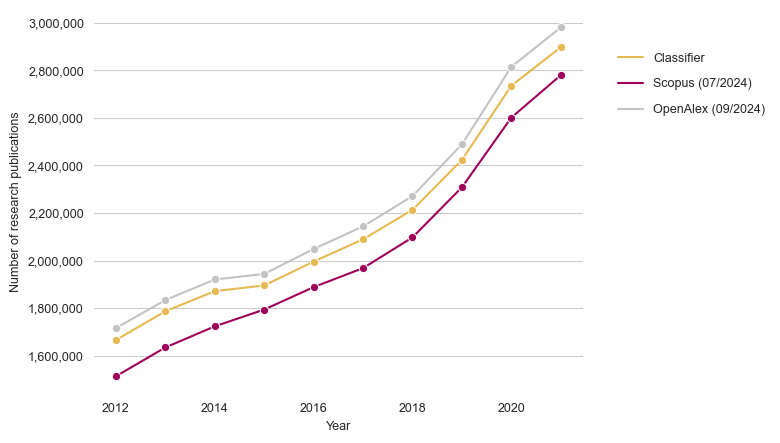

In [31]:
fig, ax = plt.subplots(figsize=(6,4.5))
plt.box(False)

sns.lineplot(data=oal_n,
             x='publication_year',
             y='n',
             color='#c3c3c3',
             marker='o',
             ax=ax)

sns.lineplot(data=scp_n,
             x='publication_year',
             y='n',
             color='#9e0059',
             marker='o',
             ax=ax)

sns.lineplot(data=dt_n,
             x='publication_year',
             y='n',
             color='#E5BA52',
             marker='o',
             ax=ax)

ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
ax.grid(False, which='both', axis='x')
ax.set(xlabel='Year', ylabel='Number of research publications')

clas_patch = Line2D([0], [0], color='#E5BA52', label='Classifier')
scp_patch = Line2D([0], [0], color='#9e0059', label='Scopus (07/2024)')
oal_patch = Line2D([0], [0], color='#c3c3c3', label='OpenAlex (09/2024)')

lgd = fig.legend(handles=[clas_patch, scp_patch, oal_patch], frameon=False,
                 bbox_to_anchor=(1.3, 0.9), labelspacing=1.1)

plt.tight_layout()

plt.show()
fig.savefig(f'media/oal_scp_comparison.png', format='png', bbox_inches='tight', dpi=500)